In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import time
from datetime import timedelta
import math
import os

import prettytensor as pt 

In [2]:
import cifar10   ### Predefined module

In [3]:
cifar10.data_path = "data/CIFAR-10/"

In [4]:
cifar10.maybe_download_and_extract()

Data has apparently already been downloaded and unpacked.


In [5]:
class_names = cifar10.load_class_names()
class_names

Loading data: data/CIFAR-10/cifar-10-batches-py/batches.meta


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [6]:
images_train, cls_train, labels_train = cifar10.load_training_data()
## returns images, cls no, labels as hot encoding

Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_1
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_2
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_3
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_4
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_5


In [7]:
images_test, cls_test, labels_test = cifar10.load_test_data()

Loading data: data/CIFAR-10/cifar-10-batches-py/test_batch


In [8]:
print('Sie of --')
print('Training Set:\t\t{}'.format(len(images_train)))
print('Test Set:\t\t{}'.format(len(images_test)))

Sie of --
Training Set:		50000
Test Set:		10000


In [9]:
from cifar10 import img_size, num_channels, num_classes ### predefined constants

In [10]:
img_size_cropped = 24

In [11]:
def plot_images(images,cls_true,cls_pred=None,smooth=True):
    
    assert len(images)==len(cls_true)==9 ##assert--> represents the necessary conditions if true then Okay otherwise 
    ### if False it will raise error
    
    fig,axes = plt.subplots(3,3)
    
    if cls_pred is None:
        hspace=0.3  ##hspace reprsents height space b/w subplots
        
    else:
        hspace=0.6
    fig.subplots_adjust(hspace=hspace,wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        
        if smooth:
            interpolation='spline16'
        else:
            interpolation='nearest'
            
        ax.imshow(images[i,:,:,:],interpolation=interpolation)
        
        cls_true_name = class_names[cls_true[i]]
        
        if cls_pred is None:
            
            xlabel = 'True:{0}'.format(cls_true_name)
            
        else:
            
            cls_pred_name = class_names[cls_pred[i]]
            xlabel = 'True:{0}\nPred:{1}'.format(cls_true_name,cls_pred_name)
            
        ax.set_xlabel(xlabel)
        
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.show()
    

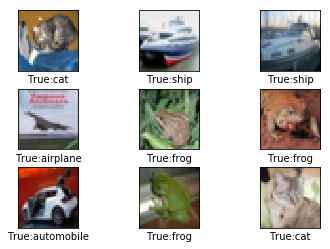

In [12]:
images = images_test[0:9]

cls_true = cls_test[0:9]

plot_images(images,cls_true,smooth=False)

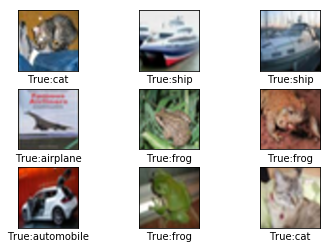

In [13]:
plot_images(images,cls_true,smooth=True)

In [14]:
###Tensorflow has the standard shape for all the features x--- where None is no. of images
x = tf.placeholder(tf.float32,shape=[None,img_size,img_size,num_channels],name='x')

y_true = tf.placeholder(tf.float32,shape=[None,num_classes],name='y_true')

y_true_cls = tf.argmax(y_true,axis=1)

In [15]:
###Preprocessing image----> Training---crop,hue,saturation,flip
###---->Test---only crop

def pre_process_image(image,training):
    ####--image-->It recieves a single image as input
    ## training---> It is a boolean to show whether it is trainig or not
    
    if training:
        
        image  = tf.random_crop(image,size = [img_size_cropped,img_size_cropped,num_channels])
        
        image = tf.image.random_flip_left_right(image)
        
        image = tf.image.random_hue(image, max_delta=0.05)
        image = tf.image.random_contrast(image, lower=0.3, upper=1.0)
        image = tf.image.random_brightness(image, max_delta=0.2)
        image = tf.image.random_saturation(image, lower=0.0, upper=2.0)
        
        ###Now values of these functions may result pixels to exceed beyond [0,1]
        ###Therefore we limit it within [0,1]
        
        image = tf.maximum(image,0.0)
        image = tf.minimum(image,1.0)
        
    else:
        
        image = tf.image.resize_image_with_crop_or_pad(image,target_height=img_size_cropped,target_width=img_size_cropped)
        
    return image

In [16]:
### Above function is applied only on 1 image now we will apply it on all the images
def pre_process(images,training):
    images = tf.map_fn( lambda image: pre_process_image(image,training), images)
    return images

In [17]:
distorted_images = pre_process(images = x, training = True)
##Distoreted images stores all the preprocessed training image

In [18]:
def main_network(images,training):
    
    x_pretty = pt.wrap(images) ##Input images are wrapped to form pretty tensor object
    
    ###VIMP---> To distinguish b/w training and test
    if training:
        phase = pt.Phase.train   
        
    else:
        phase = pt.Phase.infer
    
    with pt.defaults_scope(activation_fn=tf.nn.relu, phase=phase):
        y_pred, loss = x_pretty.\
            conv2d(kernel=5, depth=64, name='layer_conv1', batch_normalize=True).\
            max_pool(kernel=2, stride=2).\
            conv2d(kernel=5, depth=64, name='layer_conv2').\
            max_pool(kernel=2, stride=2).\
            flatten().\
            fully_connected(size=256, name='layer_fc1').\
            fully_connected(size=128, name='layer_fc2').\
            softmax_classifier(num_classes=num_classes, labels=y_true)
            
    return y_pred,loss
        

In [19]:
### Function that combines both---> main_processing and pre_processing
def create_network(training):
    ## Wraps the network in a scope
    ## By doing this---> we are basically forming 2 networks, we are reusing variables from training in testing
    with tf.variable_scope('network',reuse =not training): ###i.e training not reused
        
        images = x  ##x defined as placeholder earlier 
        ##In Following we are creating ""tensorflow graph"" 
        images = pre_process(images=images,training=training)  ###Preprocessing
         
        y_pred,loss = main_network(images=images,training=training) ###Main Processing
        
    return y_pred,loss

### Network for training-->

In [20]:
global_step = tf.Variable(initial_value = 0, name = 'global_step',trainable=False)
##Tensorflwo variable---> created for counting no. optimization iterations starting from 0
### trainable = false means tensorflow will not optimize it

In [21]:
_,loss = create_network(training=True)
## Network for training====Hence True---> y_pred is not neede hence ignored

In [22]:
print("Hello")

Hello


In [23]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss,global_step=global_step)
###This will minimize only loss and incremet global_step by one

### Network for test--->

In [24]:
y_pred,_ = create_network(training=False)
### Network is created for test phase Here we do not need losss but only y_pred

In [25]:
y_pred_cls = tf.argmax(y_pred,axis=1)
## Y_pred is in hot encoded form hence we find the int class

In [27]:
correct_prediction = tf.equal(y_pred_cls,y_true_cls) ## Created a vector of booleans

accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32)) ## vector of booleans casted to float then found their mean
### IMP---> reduce_mean is taking mean ony

### ----->

In [28]:
saver = tf.train.Saver() ### Created a saver object 
### Used for saving and retrieving variables from tensorflow graph

In [31]:
### Earlier we used layer_conv1 and layer_conv2 as layer names[ they are also variable scope] now we are getting variabels
def get_weights_variable(layer_name):
    
    with tf.variable_scope("network/" + layer_name, reuse = True):  ###Remember to add---->"|"
        variable = tf.get_variable('weights')  ### Retrieving variables named weights
        
    return variable

In [32]:
weights_conv1 = get_weights_variable(layer_name = 'layer_conv1')  ### remember to pass them as string
weights_conv2 = get_weights_variable(layer_name='layer_conv2')

In [35]:
### To get output from convolutional layer
def get_layer_output(layer_name):
    
    tensor_name = "network/" + layer_name + "/Relu:0" ### Since we are using relu activation function
    
    tensor  = tf.get_default_graph().get_tensor_by_name(tensor_name)### thsi is the tensor that is output by convolutional layer
    
    return tensor

In [36]:
output_conv1 = get_layer_output(layer_name = 'layer_conv1')
output_conv2 = get_layer_output(layer_name = 'layer_conv2')

In [37]:
##Now graph is created now we have to start executing it
### Create a session
session = tf.Session()

In [38]:
save_dir = 'checkpoints/'  ## directory which will store variables during training

In [39]:
if not os.path.exists(save_dir): ### i.e if directory doesnot exists we are creating a directory
    os.makedir(save_dir)

In [40]:
save_path = os.path.join(save_dir, 'cifar10_cnn') ## Base filename for checkpoints

In [42]:
##Now we try to load last checkpoint 
## Raise error if not found --> hence use try and except concept

try:
    print("Trying to restore last checkpoint---->")
    
    last_chk_path = tf.train.latest_checkpoint(checkpoint_dir = save_dir)## lastest checkpoint at "save_dir" directory
    
    saver.restore(session,save_path = last_chk_path) ## which point to restore from saver
    
    print("Restored checkpoint from:",last_chk_path)
except:
    print("Failed to restore checkponts---.Initializing variables instaed.")
    session.run(tf.global_variables_initializer())

Trying to restore last checkpoint---->
INFO:tensorflow:Restoring parameters from checkpoints/network4
Failed to restore checkponts---.Initializing variables instaed.


In [43]:
train_batch_size = 64

In [44]:
def random_batch():
    num_images = len(images_train) 
    idx = np.random.choice(num_images,size=train_batch_size,replace=False)
    ### creates a random index replace=False means no repating
    
    x_batch = images_train[idx,:,:,:]
    y_batch = labels_train[idx,:]
    
    return x_batch,y_batch

In [45]:
def optimize(num_iterations):
    
    start_time = time.time() ###For time usage
    
    for i in range(num_iterations):
        
        x_batch, y_true_batch = random_batch()
        
        feed_dict_train = { x : x_batch, y_true : y_true_batch}
        
        i_global,_ = session.run([global_step,optimizer],feed_dict=feed_dict_train)
        ### we are running global_step also since we need global step counter i.e i+global
        
        if (i_global %100==0) or (i ==num_iterations-1):
            
            batch_acc = session.run(accuracy,feed_dict=feed_dict_train)
            ## Accuracy tensorflow graph is run and it's batch accuracy is stored in batch_acc
            msg = "Global Step: {0:>6}, Training Batch Accuracy: {1:>6.1%}"
            print(msg.format(i_global, batch_acc))
            
        if (i_global %1000==0) or (i==num_iterations-1):
            
            saver.save(session,save_path=save_path,global_step=global_step)
            
            print("Saved Checkpoint")
    
    end_time = time.time()
    
    time_dif = end_time - start_time
    
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))
            

In [46]:
def plot_example_errors(cls_pred, correct):
    
    incorrect = (correct == False)
    images = images_test[incorrect]
    cls_pred = cls_pred[incorrect]
    cls_true = cls_test[incorrect]
    plot_images(images=images[0:9],cls_true=cls_true[0:9],cls_pred=cls_pred[0:9])

In [47]:
def plot_confusion_matrix(cls_pred):
    cm = confusion_matrix(y_true=cls_test,  # True class for test-set.
                          y_pred=cls_pred)  # Predicted class.
    for i in range(num_classes):
        # Append the class-name to each line.
        class_name = "({}) {}".format(i, class_names[i])
        print(cm[i, :], class_name)

    # Print the class-numbers for easy reference.
    class_numbers = [" ({0})".format(i) for i in range(num_classes)]
    print("".join(class_numbers))

In [48]:
batch_size = 256

def predict_cls(images, labels, cls_true):
    num_images = len(images)
    
    cls_pred = np.zeros(shape=num_images, dtype=np.int)
    i = 0

    while i < num_images:
        j = min(i + batch_size, num_images)
        
        feed_dict = {x: images[i:j, :],
                     y_true: labels[i:j, :]}
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)
        i = j

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)
    
    return correct, cls_pred

In [49]:
def predict_cls_test():
    return predict_cls(images = images_test,
                       labels = labels_test,
                       cls_true = cls_test)

In [50]:
def classification_accuracy(correct):
    return correct.mean(), correct.sum()

In [51]:
def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # For all the images in the test-set,
    # calculate the predicted classes and whether they are correct.
    correct, cls_pred = predict_cls_test()
    
    # Classification accuracy and the number of correct classifications.
    acc, num_correct = classification_accuracy(correct)
    
    # Number of images being classified.
    num_images = len(correct)

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, num_correct, num_images))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

In [52]:
def plot_conv_weights(weights, input_channel=0):
    # Assume weights are TensorFlow ops for 4-dim variables
    # e.g. weights_conv1 or weights_conv2.

    # Retrieve the values of the weight-variables from TensorFlow.
    # A feed-dict is not necessary because nothing is calculated.
    w = session.run(weights)

    # Print statistics for the weights.
    print("Min:  {0:.5f}, Max:   {1:.5f}".format(w.min(), w.max()))
    print("Mean: {0:.5f}, Stdev: {1:.5f}".format(w.mean(), w.std()))
    
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)
    abs_max = max(abs(w_min), abs(w_max))

    # Number of filters used in the conv. layer.
    num_filters = w.shape[3]
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            # The format of this 4-dim tensor is determined by the
            # TensorFlow API. See Tutorial #02 for more details.
            img = w[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=-abs_max, vmax=abs_max,
                      interpolation='nearest', cmap='seismic')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [53]:
def plot_layer_output(layer_output, image):
    # Assume layer_output is a 4-dim tensor
    # e.g. output_conv1 or output_conv2.

    # Create a feed-dict which holds the single input image.
    # Note that TensorFlow needs a list of images,
    # so we just create a list with this one image.
    feed_dict = {x: [image]}
    
    # Retrieve the output of the layer after inputting this image.
    values = session.run(layer_output, feed_dict=feed_dict)

    # Get the lowest and highest values.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    values_min = np.min(values)
    values_max = np.max(values)

    # Number of image channels output by the conv. layer.
    num_images = values.shape[3]
    num_grids = math.ceil(math.sqrt(num_images))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid image-channels.
        if i<num_images:
            # Get the images for the i'th output channel.
            img = values[0, :, :, i]

            # Plot image.
            ax.imshow(img, vmin=values_min, vmax=values_max,
                      interpolation='nearest', cmap='binary')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [54]:
def plot_distorted_image(image, cls_true):
    # Repeat the input image 9 times.
    image_duplicates = np.repeat(image[np.newaxis, :, :, :], 9, axis=0)

    # Create a feed-dict for TensorFlow.
    feed_dict = {x: image_duplicates}

    # Calculate only the pre-processing of the TensorFlow graph
    # which distorts the images in the feed-dict.
    result = session.run(distorted_images, feed_dict=feed_dict)

    # Plot the images.
    plot_images(images=result, cls_true=np.repeat(cls_true, 9))

In [55]:
def get_test_image(i):
    return images_test[i, :, :, :], cls_test[i]

In [56]:
img, cls = get_test_image(16)

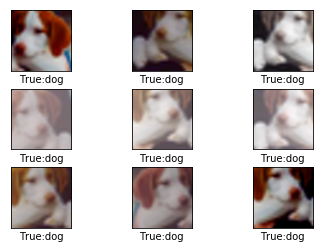

In [57]:
plot_distorted_image(img, cls)

In [59]:
if True:
    optimize(num_iterations=20000)

Global Step:    100, Training Batch Accuracy:  23.4%
Global Step:    200, Training Batch Accuracy:  34.4%
Global Step:    300, Training Batch Accuracy:  34.4%
Global Step:    400, Training Batch Accuracy:  39.1%
Global Step:    500, Training Batch Accuracy:  54.7%
Global Step:    600, Training Batch Accuracy:  35.9%
Global Step:    700, Training Batch Accuracy:  34.4%
Global Step:    800, Training Batch Accuracy:  43.8%
Global Step:    900, Training Batch Accuracy:  51.6%
Global Step:   1000, Training Batch Accuracy:  42.2%
Saved Checkpoint
Global Step:   1100, Training Batch Accuracy:  43.8%
Global Step:   1200, Training Batch Accuracy:  50.0%
Global Step:   1300, Training Batch Accuracy:  43.8%
Global Step:   1400, Training Batch Accuracy:  42.2%
Global Step:   1500, Training Batch Accuracy:  35.9%
Global Step:   1600, Training Batch Accuracy:  54.7%
Global Step:   1700, Training Batch Accuracy:  45.3%
Global Step:   1800, Training Batch Accuracy:  48.4%
Global Step:   1900, Training

Global Step:  15100, Training Batch Accuracy:  70.3%
Global Step:  15200, Training Batch Accuracy:  59.4%
Global Step:  15300, Training Batch Accuracy:  68.8%
Global Step:  15400, Training Batch Accuracy:  70.3%
Global Step:  15500, Training Batch Accuracy:  71.9%
Global Step:  15600, Training Batch Accuracy:  68.8%
Global Step:  15700, Training Batch Accuracy:  71.9%
Global Step:  15800, Training Batch Accuracy:  71.9%
Global Step:  15900, Training Batch Accuracy:  60.9%
Global Step:  16000, Training Batch Accuracy:  71.9%
Saved Checkpoint
Global Step:  16100, Training Batch Accuracy:  81.2%
Global Step:  16200, Training Batch Accuracy:  78.1%
Global Step:  16300, Training Batch Accuracy:  78.1%
Global Step:  16400, Training Batch Accuracy:  71.9%
Global Step:  16500, Training Batch Accuracy:  73.4%
Global Step:  16600, Training Batch Accuracy:  64.1%
Global Step:  16700, Training Batch Accuracy:  64.1%
Global Step:  16800, Training Batch Accuracy:  67.2%
Global Step:  16900, Training

Accuracy on Test-Set: 70.2% (7025 / 10000)
Example errors:


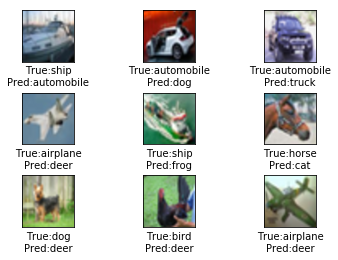

Confusion Matrix:
[702  38  41  23  33   9  11  21  57  65] (0) airplane
[  8 855   4  14   1  10  12   7  20  69] (1) automobile
[ 55   8 488 124  88  91  71  47  13  15] (2) bird
[ 11  13  35 525  52 216  60  49   7  32] (3) cat
[  9  11  26  55 671  53  49 105  12   9] (4) deer
[ 10   5  14 197  42 644  20  54   4  10] (5) dog
[  5   7  26  74  44  28 795  11   2   8] (6) frog
[  7   6   7  45  58  85  11 758   1  22] (7) horse
[ 56  54   8  26  12   9   5   5 780  45] (8) ship
[ 13 108   8  16  10   8   5   8  17 807] (9) truck
 (0) (1) (2) (3) (4) (5) (6) (7) (8) (9)


In [60]:
print_test_accuracy(show_example_errors=True,
                    show_confusion_matrix=True)